# Part 6.2 - Analysis Topic Model of Train Set
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
#plt.style.use('seaborn-darkgrid')
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline

In [2]:
def filter_topics(df, topic_lsit):
    # remove data out of df if topic is not in topic_list
    return (df[df['topic'].isin(topic_list)].sort_values(by='topic', ascending=True))

In [3]:
def plot_topics(df, kind='', adjust_top=0.97, title='', height=3.5, col_wrap=2):
    if kind == 'scatter':
        g = sns.catplot(x="year", y='weight', hue="topic", col='keywords', col_wrap=col_wrap, 
                        kind='strip', height=height, aspect=2, jitter=1, dodge=False, s=5, legend=False,
                        data=df)
        g.fig.suptitle("Dominant Topics Distribution of {}".format(title), fontsize=16)
        
    elif kind == 'bar':
        g = sns.catplot(x="year", hue="topic", col='keywords', col_wrap=col_wrap, 
                        kind='count', height=height, aspect=2, dodge=False, legend=False, 
                        data=df)
        g.fig.suptitle("Dominant Topics Count of {}".format(title), fontsize=16)
        
    elif kind == 'point':
        g = sns.catplot(x="year", y='weight',  col='keywords', col_wrap=col_wrap, 
                        kind='point', height=height, aspect=2, dodge=False, s=1, legend=False, 
                        markers='.', scale=0.5,
                        data=df)
        g.fig.suptitle("Average Weight of {}".format(title), fontsize=16)
        
    else:
        print('wrong kind.')
        
    g.fig.subplots_adjust(top=adjust_top)
    g.set_xticklabels(rotation=90, step=2)
    return g

**For computing resource limitation, we did not train the full dataset, but trained a random sampling dataset (train set). In this part, we will use the topic modeling result from part 6.1 to analysis the train set to make a general analysis.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.head(5)

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00755   
1       1  0.00467   
2       2  0.01173   
3       3  0.00726   
4       4  0.00409   

                                                                            keywords_  
0               council city borough mayor town water street councillor works supply   
1      blenheim marlborough picton street wairau griffiths market road high havelock   
2                                years man time london made ago great lady day young   
3                       wool sheep stock company agents sale produce dip sales grain   
4  freight apply passage steam company passengers new_zealand tons agents wellington

**Docmument - dominant topics dataframe:**

In [6]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [7]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.head(5)

Shape of dataframe: (1511227, 6)


id    region  year  topic    weight  \
0  1854215  Auckland  1862    100  0.290705   
1  1854224  Auckland  1862     35  0.966307   
2  1854233  Auckland  1863    146  0.382336   
3  1854245  Auckland  1863      4  0.295399   
4  1854248  Auckland  1863    123  0.569472   

                                                          keywords  
0  advertisements office news times paper published column adve...  
1             love life heart day thy world eyes long man night...  
2  business public attention begs orders stock goods notice pre...  
3  freight apply passage steam company passengers new_zealand t...  
4           public men people man good time law fact great case...

**Average topic weight dataframe:**

In [8]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

In [9]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.head(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
0  1839      0  0.000022   
1  1839      1  0.000014   
2  1839      2  0.000034   
3  1839      3  0.000021   
4  1839      4  0.000012   

                                                          keywords  
0  council city borough mayor town water street councillor work...  
1  blenheim marlborough picton street wairau griffiths market r...  
2          years man time london made ago great lady day young ...  
3  wool sheep stock company agents sale produce dip sales grain...  
4  freight apply passage steam company passengers new_zealand t...

## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means it is the most distict document in the corpus, easy to find the topic by eyes. Here we print the top one of them.**

In [10]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

id      region  year  topic    weight  \
853279  17602427  Wellington  1930     20  0.999020   
811655  16981879  Wellington  1931     20  0.998672   
979566  19315821  Wellington  1929     20  0.998294   

                                                               keywords  
853279  auckland wellington left due london lyttelton october august...  
811655  auckland wellington left due london lyttelton october august...  
979566  auckland wellington left due london lyttelton october august...

In [11]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

17602427

In [12]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 17602427
853280:17602427	SHIPPING NEWS	SHIPPING NEWSHIGH WATER. To-day—4.l a.m.; 4.29 p.m. To-morrow — 5.3 a.m.; 5.33 p.m. ARRIVALS. WEDNESDAY, 12tll FEBRUARY. HAWERA. s:s. (10.30 p.m.), 174 'tons, Brigden, from Patea. KAFUM, 5.3. (10.50 p.m.), 275 tons, M'Lachlan, from Patea. LViHA, m.s. (11.50 p.m.), 251 toes, Gibson, from Fatea. THURSDAY, 13th FEBRUARY. LVAIIA, m.s. (12.25 a.m.), 251 tons, Gibson, from l'atca. KUKOW, s.s. (2.30 a.m.), 2025 tons. Grey, from Portland. AKAHURA, s.s. (4.50 a.m.), 1506' tons. Wildman, from Nelson. KAIKORAI, s.s. (5.25 a.m.), 3151 lons, Watsoli, from Wcstport. OPAWA, m.s. (5.30 a.m.), 110 tons, Kadford, from Blenheim. MAORI, s.s. (7.5 a.m.), 318S tons, from Lyttelton. ROTORUA, s.s. (7.5 a.m.). 12,112 tons. Hunter, from Napier. NIKAU, s.s. (9.20 a.m.), 248 tons, MacMillan, from Motueka. OPIHI, s.s. (9.30 a.m.), 1117 tons, Chatfield, from New Plymouth. DEPARTURES. WEDNESDAY, 12th FEBRUARY. WESTMORELAND,'s.s. (3.4S p.m.)

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the first 20 topics in topics list.**

In [13]:
df_plt = df_topics.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords_'].map(addWeight)

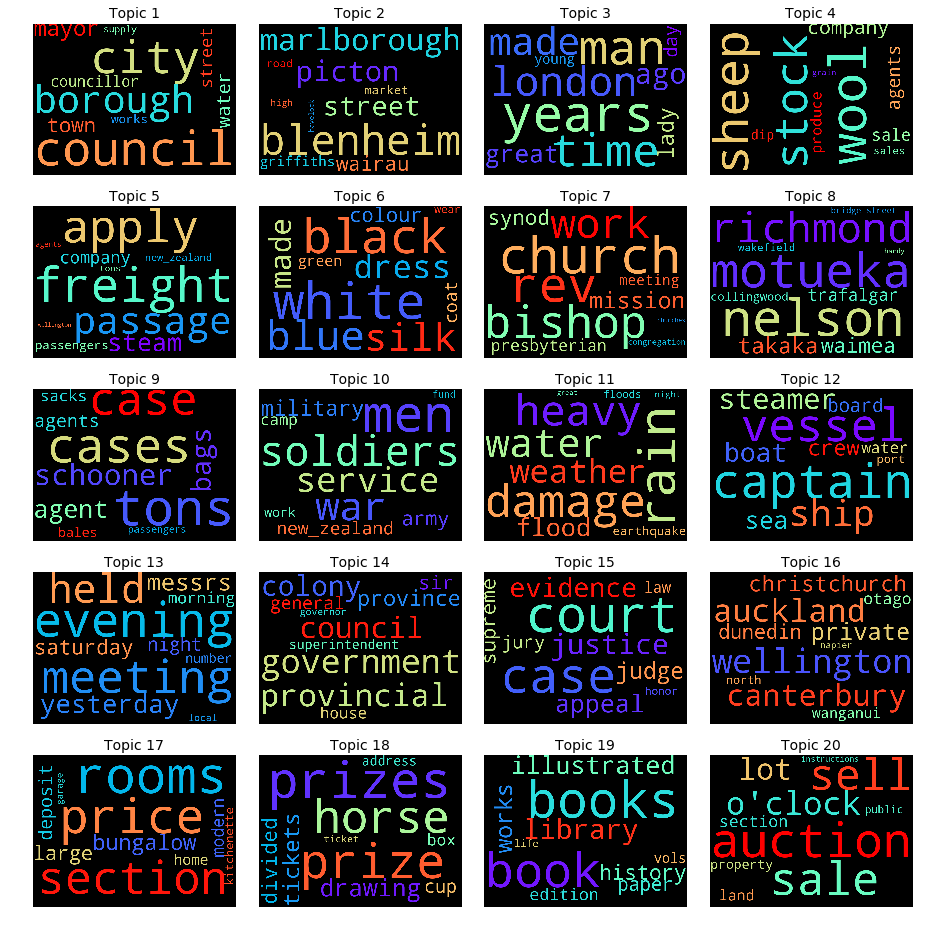

In [14]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i+1), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general.**

In [1]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.6,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Year in General", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

NameError: name 'sns' is not defined

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

In [16]:
df_topics.sort_values(by='topic_', ascending=True).head(10)

topic_  weight_  \
66       66  0.04405   
60       60  0.03965   
87       87  0.02435   
46       46  0.01849   
69       69  0.01693   
176     176  0.01664   
153     153  0.01603   
146     146  0.01454   
39       39  0.01451   
142     142  0.01430   

                                                                                       keywords_  
66                                                  aro tin ill oil zealand day ton lit mil tie   
60             association press received telegraph copyright london united electric july cable   
87                                         good time year work made great present week day fact   
46                               messrs john smith james william thomas wilson brown george mrs   
69                       question matter time present made opinion system thought position make   
176                              letter sir editor made public matter statement time paper give   
153             dunedin street otago invercargill princes george southland gore south balclutha   
146                    business public attention begs orders stock goods notice premises inform   
39                        advertisements column street prices phone good quality price free buy   
142  association meeting conference union committee wellington council new_zealand held decided

**Generate dominant topics dataframe for plot:**

In [17]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

List of topics to plot: [66, 60, 87, 46, 69, 176, 153, 146, 39, 142]
Shape of dataframe: (112762, 6)
Shape of dataframe: (1040, 4)


**Dominant topics distribution over year:**

In [18]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

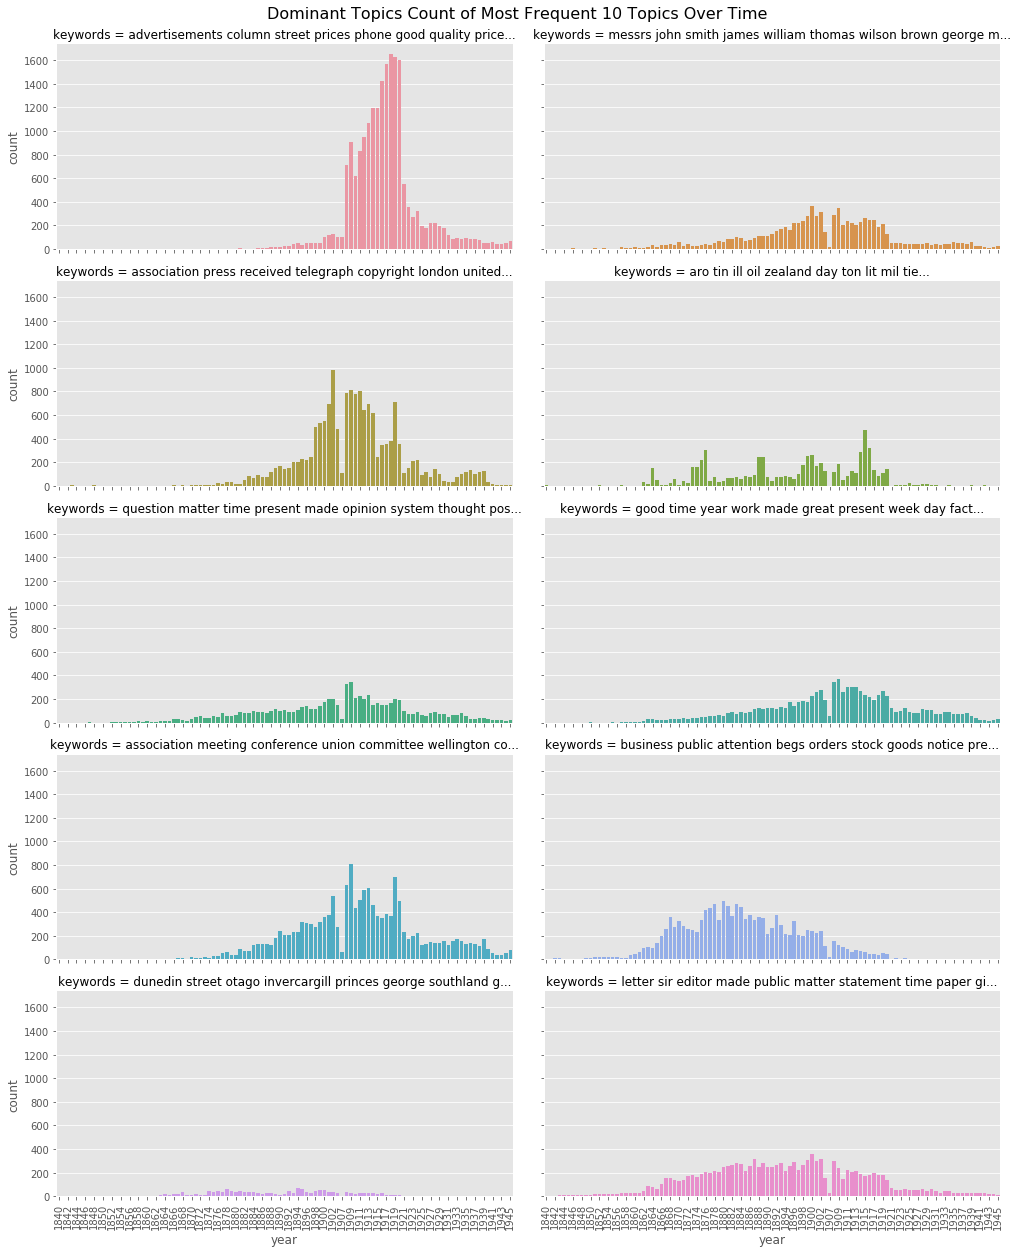

In [19]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

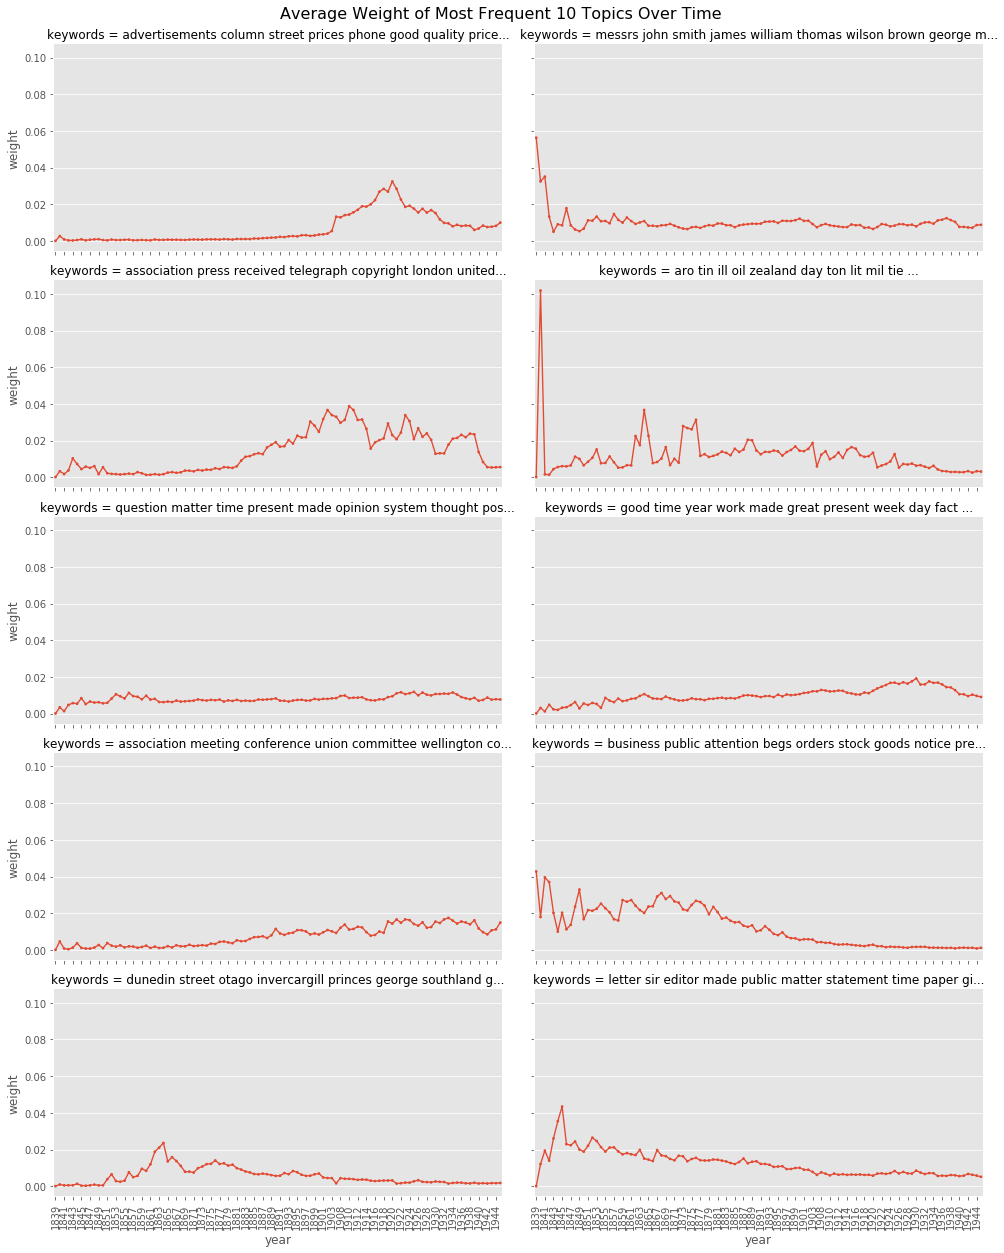

In [20]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='First 10 Topics Over Year',
            height=3.5,
            col_wrap=2)

### 5 The Most Very Topics

**By caculating the std of weight of each topic, we get the most very topics. Some weights of topic may vary follow the overall trends, it's better to remove the effect of overall weight for more accurate evaluation. Here we ignore the effect of overall trends.**

In [21]:
topic_list = df_avgweight.groupby('topic')['weight'].std().sort_values(ascending=False).index[:10]

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of dataframe:', df_plt_dom.shape)
print('Shape of dataframe:', df_plt_avg.shape)

List of topics to plot: Int64Index([193, 161, 154, 8, 168, 77, 79, 13, 129, 36], dtype='int64', name='topic')
Shape of dataframe: (103927, 6)
Shape of dataframe: (1040, 4)


**Dominant topics distribution over year:**

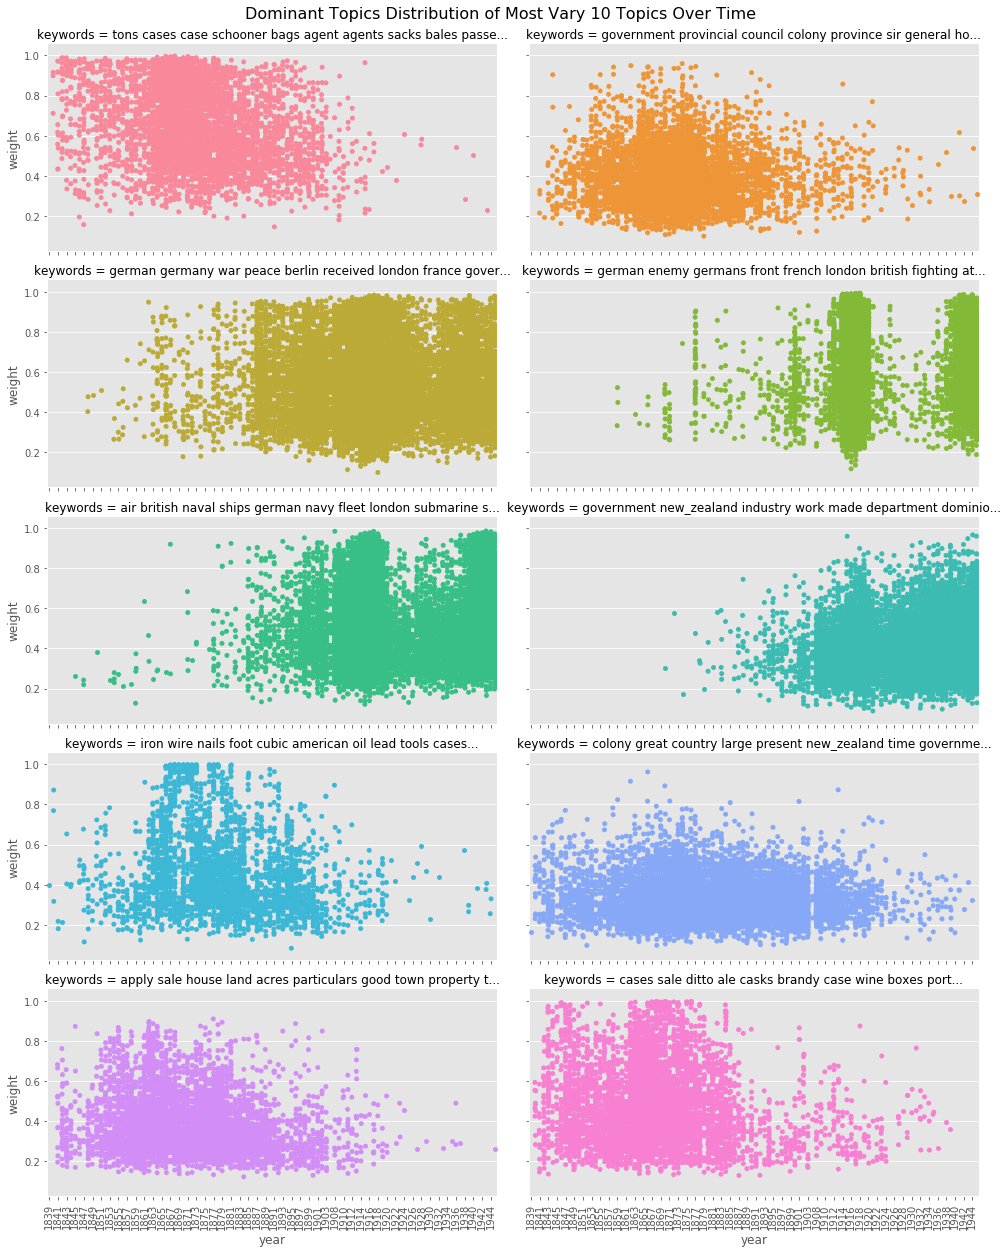

In [22]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

In [23]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

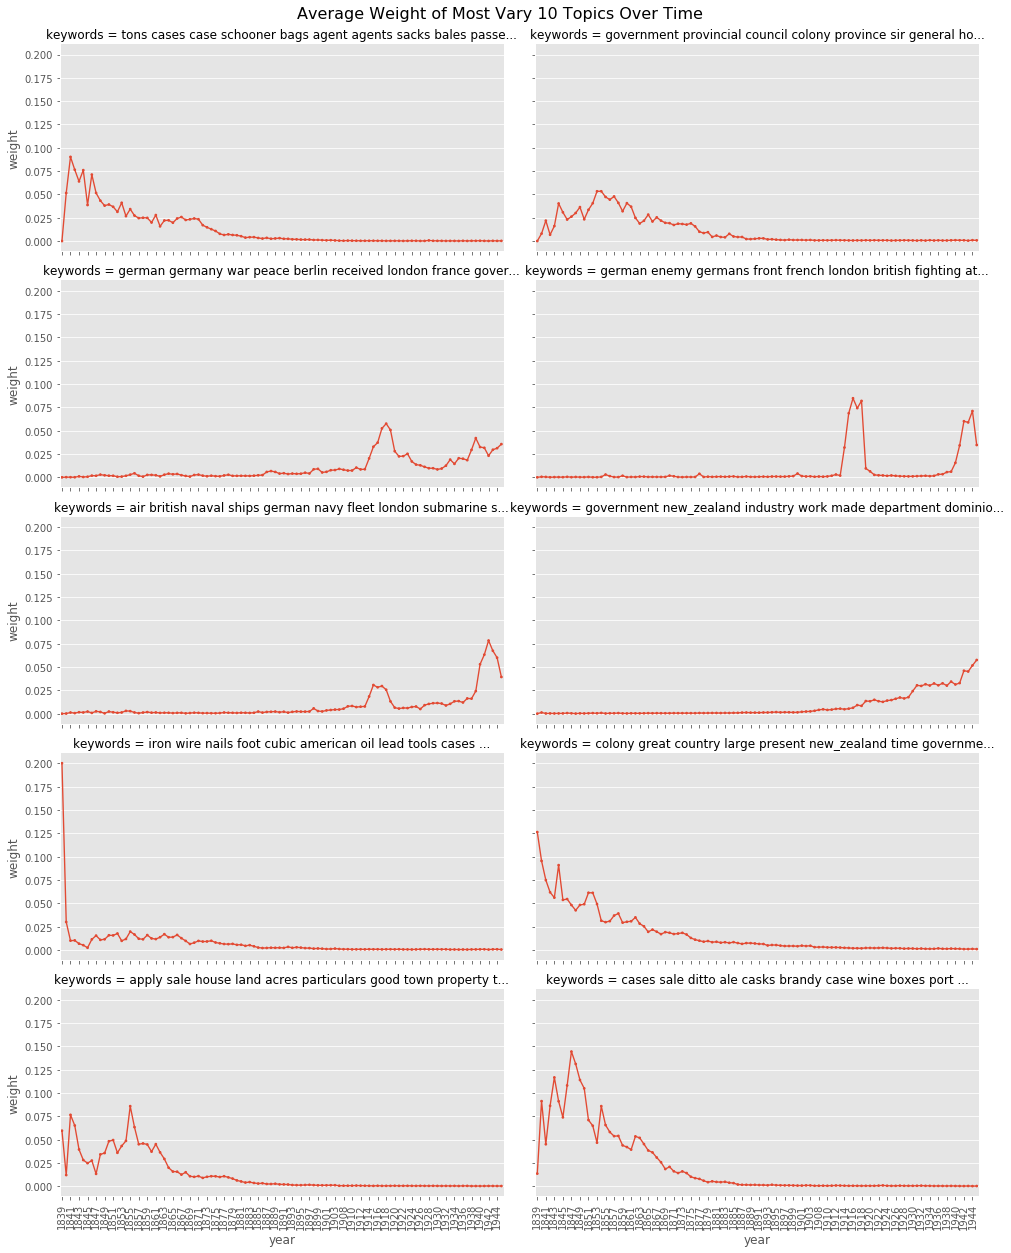

In [24]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

## 2 Topic Model from Range of Time

**Perform the same process with analyzing topic model from train set, the topic model is from WWI dataset, please notice the time unit here is month.**

### 2.1 Load dataframes

**The topics List is the same with other subset but the weight is recalculated because the time range is different:**

In [25]:
path = r'../models/wwi/topicKeys.csv'

df_topics_wwi = (pd.read_csv(path, 
                             header=None, 
                             index_col=None, 
                             names = ['topic_', 'weight_', 'keywords_'],
                             encoding='utf8')
                 .sort_values(by='topic_')
                 .reset_index(drop=True))

topics_shape = df_topics_wwi.shape

In [26]:
print('Shape of dataframe:', topics_shape)
df_topics_wwi.head(5)

Shape of dataframe: (200, 3)


topic_   weight_  \
0       0  0.002288   
1       1  0.001280   
2       2  0.051251   
3       3  0.003137   
4       4  0.001332   

                                                                            keywords_  
0               council city borough mayor town water street councillor works supply   
1      blenheim marlborough picton street wairau griffiths market road high havelock   
2                                years man time london made ago great lady day young   
3                       wool sheep stock company agents sale produce dip sales grain   
4  freight apply passage steam company passengers new_zealand tons agents wellington

**Docmument - dominant topics dataframe:**

In [27]:
path = r'../models/wwi/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [28]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.head(5)

Shape of dataframe: (283114, 6)


id   region     year  topic    weight  \
0  3024904  unknown  1912-01     33  0.228992   
1  3025071  unknown  1912-01     87  0.192616   
2  3026239  unknown  1912-02    123  0.149367   
3  3026663  unknown  1912-03     66  0.207507   
4  3028687  unknown  1912-04    123  0.133431   

                                                          keywords  
0  leave train daily coach mail leaves trains coaches return pa...  
1          good time year work made great present week day fact...  
2           public men people man good time law fact great case...  
3                   aro tin ill oil zealand day ton lit mil tie...  
4           public men people man good time law fact great case...

**Average topic weight dataframe:**

In [29]:
path = r'../models/wwi/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics_wwi, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,65)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

In [30]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.head(5)

Shape of dataframe: (24000, 4)


year  topic    weight  \
0  1912-01      0  0.002000   
1  1912-01      1  0.001165   
2  1912-01      2  0.043108   
3  1912-01      3  0.003298   
4  1912-01      4  0.001687   

                                                               keywords  
0  council city borough mayor town water street councillor works sup...  
1  blenheim marlborough picton street wairau griffiths market road h...  
2               years man time london made ago great lady day young ...  
3      wool sheep stock company agents sale produce dip sales grain ...  
4  freight apply passage steam company passengers new_zealand tons a...

### 2.1 The Most Distinct Documents

In [31]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

id      region     year  topic    weight  \
68506  16541987  West Coast  1919-06    147  0.943439   
64691  16461119  West Coast  1919-06    147  0.926890   
68497  16541774  West Coast  1919-06    147  0.917219   

                                                           keywords  
68506  farmers milk wheat crop crops sheep land farm farmer good...  
64691  farmers milk wheat crop crops sheep land farm farmer good...  
68497  farmers milk wheat crop crops sheep land farm farmer good...

In [32]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

16541987

In [33]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 16541987
780876:16541987	TIDES.	TIDES.June 6—3.15 a.m; 3.42 p.m. June 7 — 4.10 a.m.; 4.35 p.m. June 8 — 5.5 a.m.; 5.40 p.m. June 9— 6.10 a.m; 6.43 p.m. June 10—7.12 a.m.; 7.40 p.m. June 11— 8.10 a.m.; 8.35 p.m. June 12 — 9.5 a.m ; 9.30 p.m. June 13 — 9.57 a.m.; 10.20 p.m. June 14c — 10.40 a.m; 11.4 p.m. June 15 — 11.25 a.m.; 11.47 p.m. June 16 ; 0.10 p.m. June 17 — 0.33 a.m; 0.53 p.m. June 18—1.18 a.m; 1.40 p.m. Jttue 19—2.5 a.m.; 2.28 p.m. June 20 — 2.55 a.m.; 3.23 p.m. June 21 — 3.50 a.m; 4.20 p.m. June 22—4.50 a.m; 5.26 p.m. June 23—6.2 a.m ; 6.35 p.m. June 24 — 7.7 a.m; 7.37 p.m. June 25 — 8.3 a.m: 8.30 p.m. June 26—8.57 a.m: 9.23 p.m. June 27 — 9.47 a.m; 10.11 p.m. June 28—10.34 a.m; 10.54 p.m. June 29—11.15 a.m; 11.34 ' p.m. June 30 — 11.53 a.m-.


### 2.2 General Distribution of Topics

#### 2.2.1 Word Cloud

In [34]:
df_plt = df_topics_wwi.copy(deep=True)

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords_'].map(addWeight)

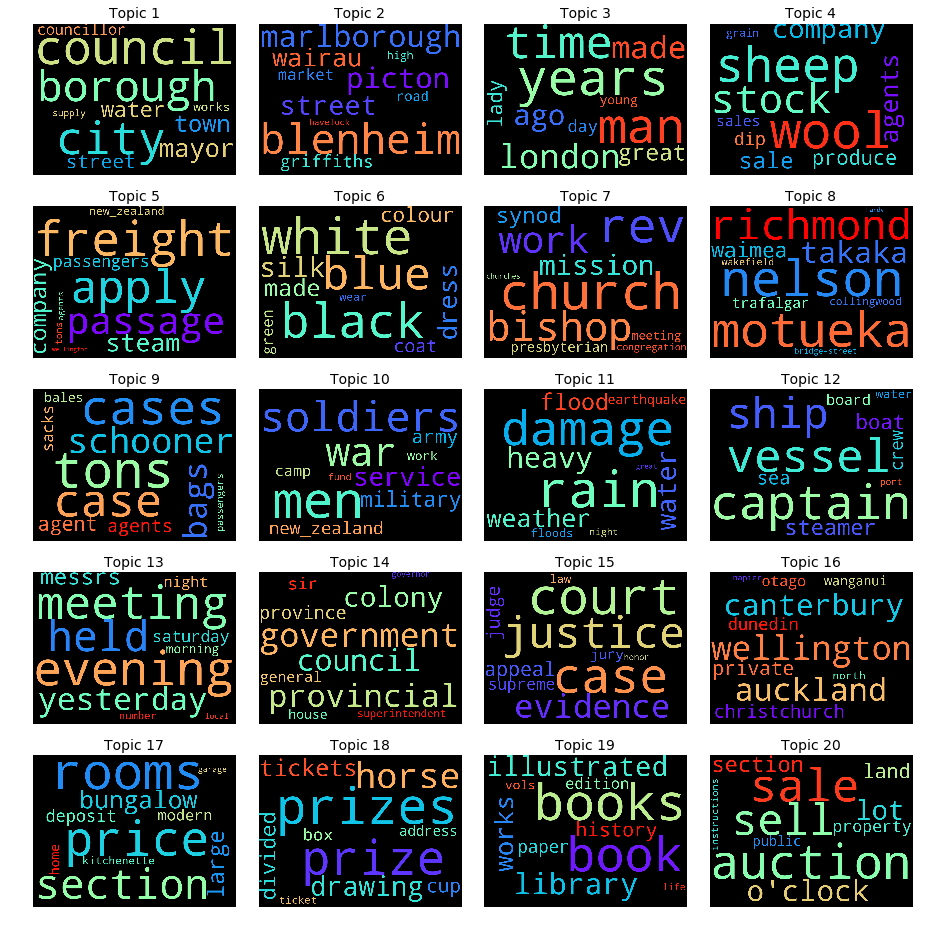

In [35]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i+1), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### 2.2.2 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution.**

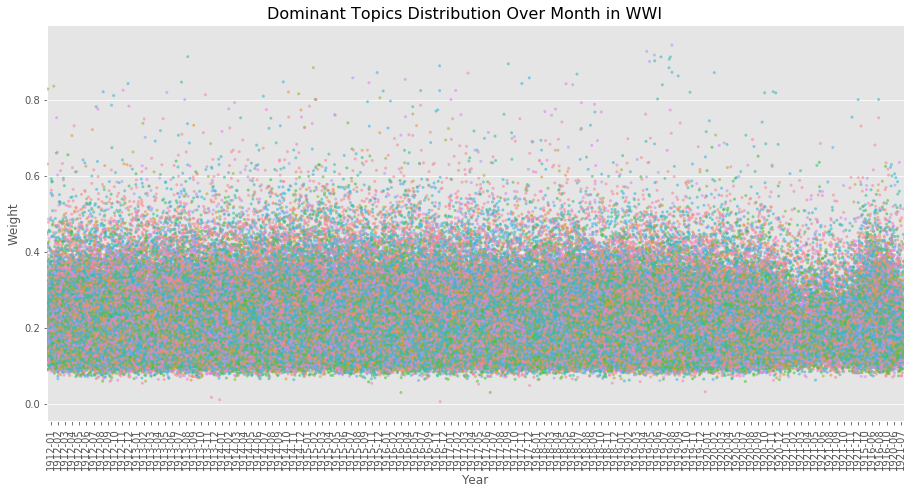

In [36]:
g = sns.catplot(x="year", y='weight', hue='topic',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=3, alpha=0.6,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Month in WWI", fontsize=16)
g.set(xlabel='Year', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 2.3 The Most Frequent Topics

In [37]:
df_topics_wwi.sort_values(by='weight_', ascending=False).head(10)

topic_   weight_  \
66       66  0.058640   
123     123  0.058071   
2         2  0.051251   
150     150  0.018527   
78       78  0.015740   
161     161  0.014132   
46       46  0.013864   
35       35  0.013781   
176     176  0.013671   
104     104  0.013379   

                                                                       keywords_  
66                                  aro tin ill oil zealand day ton lit mil tie   
123                         public men people man good time law fact great case   
2                           years man time london made ago great lady day young   
150                           time back men man left made round side head night   
78                  water food body time disease found air animal animals blood   
161  colony great country large present new_zealand time government made public   
46               messrs john smith james william thomas wilson brown george mrs   
35                            love life heart day thy world eyes long man night   
176              letter sir editor made public matter statement time paper give   
104           innings wickets cricket runs match team bowling total wicket made

**Generate dominant topics dataframe for plot:**

In [38]:
topic_list = df_topics_wwi.sort_values(by='weight_', ascending=False).topic_[:10].tolist()

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of dataframe:', df_plt_dom.shape)
print('Shape of dataframe:', df_plt_avg.shape)

List of topics to plot: [66, 123, 2, 150, 78, 161, 46, 35, 176, 104]
Shape of dataframe: (144550, 6)
Shape of dataframe: (1200, 4)


**Dominant topics distribution over month:**

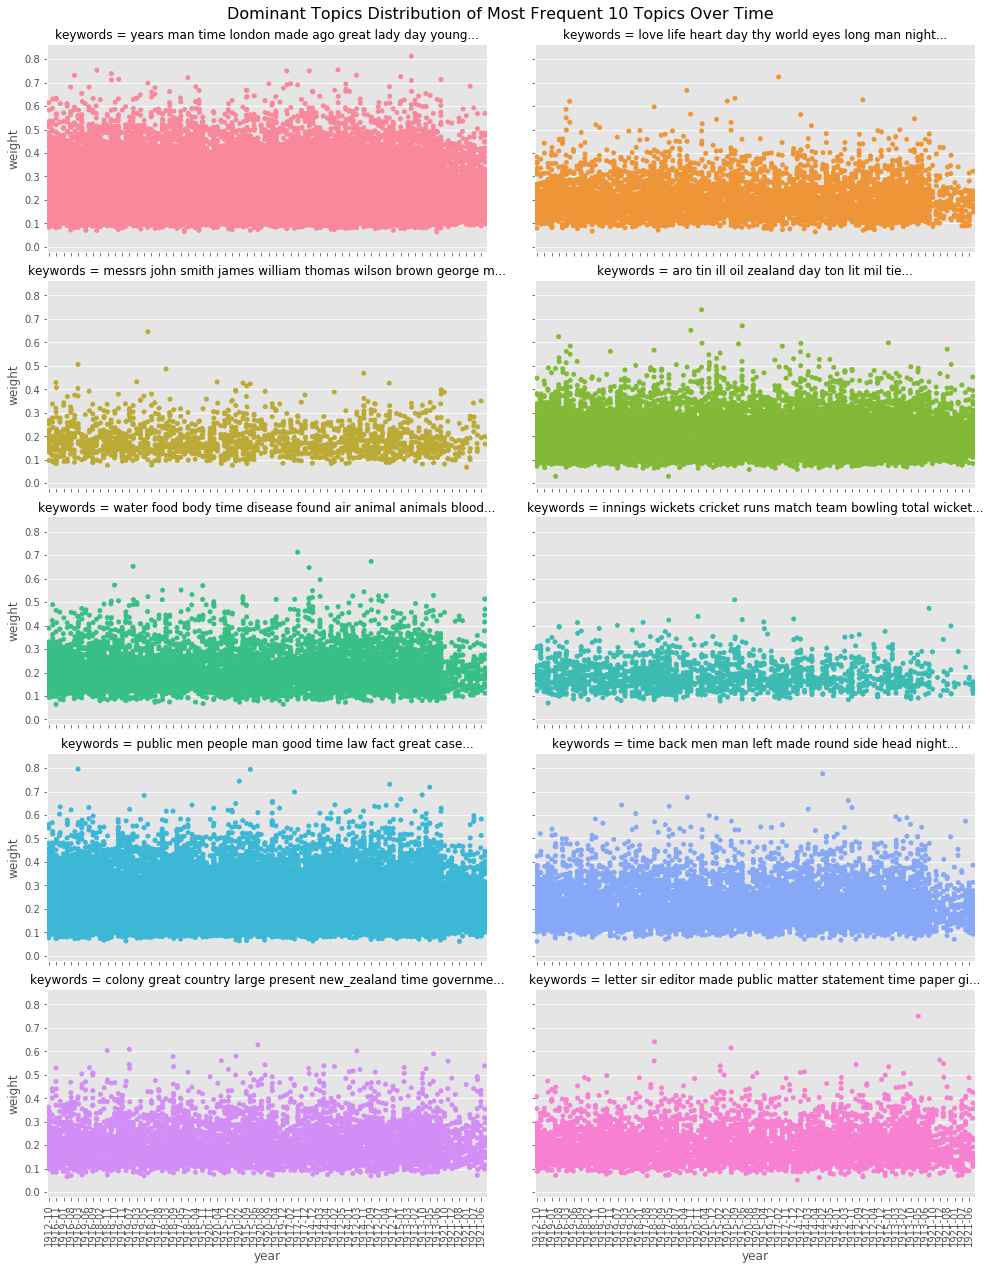

In [39]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='Most Frequent 10 Topics',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

In [40]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='Most Frequent 10 Topics',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

In [41]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='Most Frequent 10 Topics',
            height=3.5,
            col_wrap=2)

### 2.4 The Most Very Topics

In [42]:
topic_list = df_avgweight.groupby('topic')['weight'].std().sort_values(ascending=False).index[:10]

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)

df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of dataframe:', df_plt_dom.shape)
print('Shape of dataframe:', df_plt_avg.shape)

List of topics to plot: Int64Index([179, 123, 21, 147, 165, 2, 66, 119, 50, 104], dtype='int64', name='topic')
Shape of dataframe: (119209, 6)
Shape of dataframe: (1200, 4)


**Dominant topics distribution over month:**

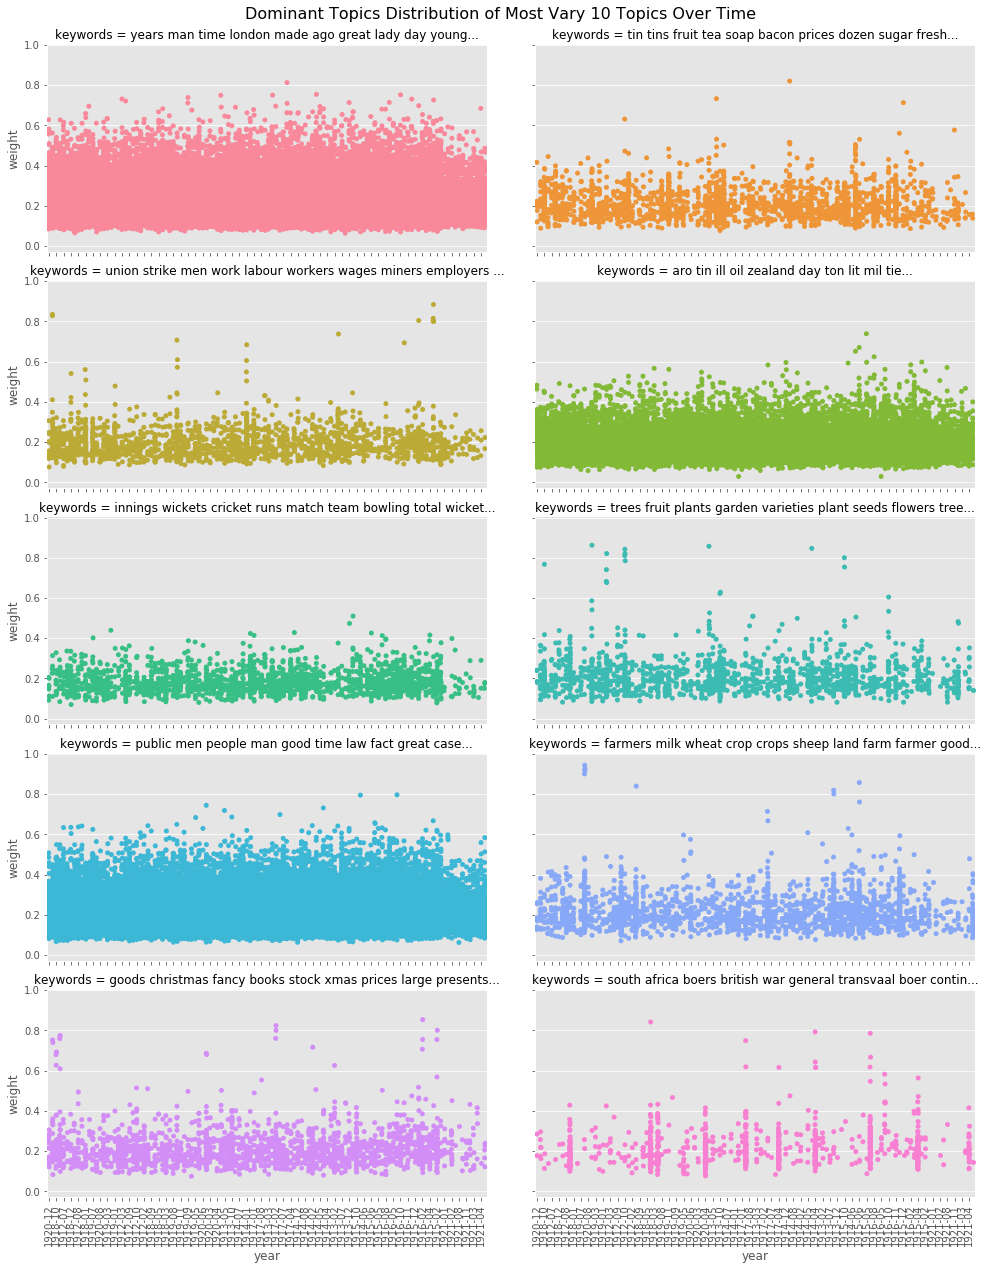

In [43]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

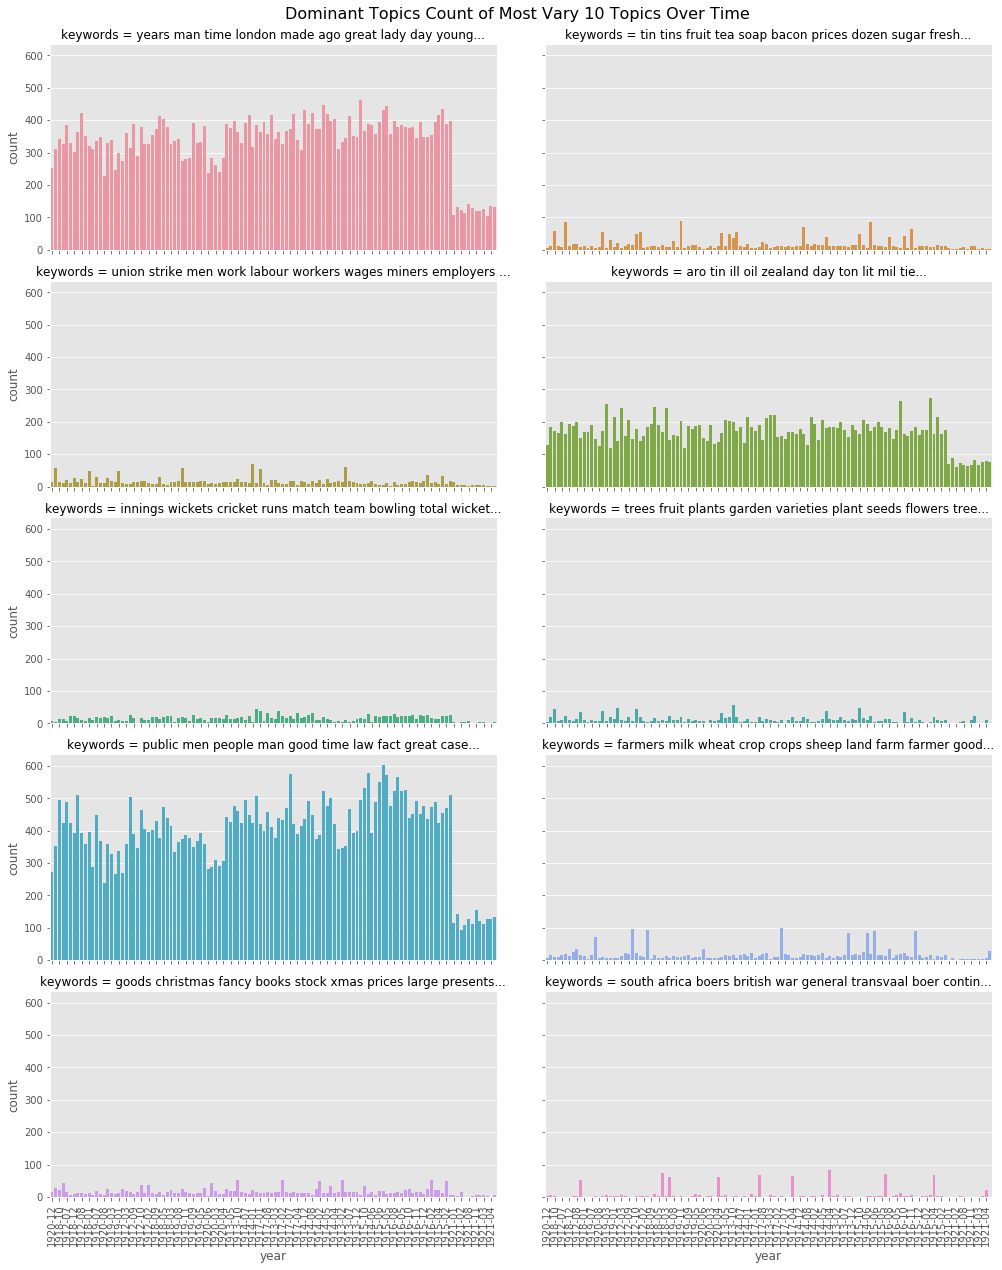

In [44]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

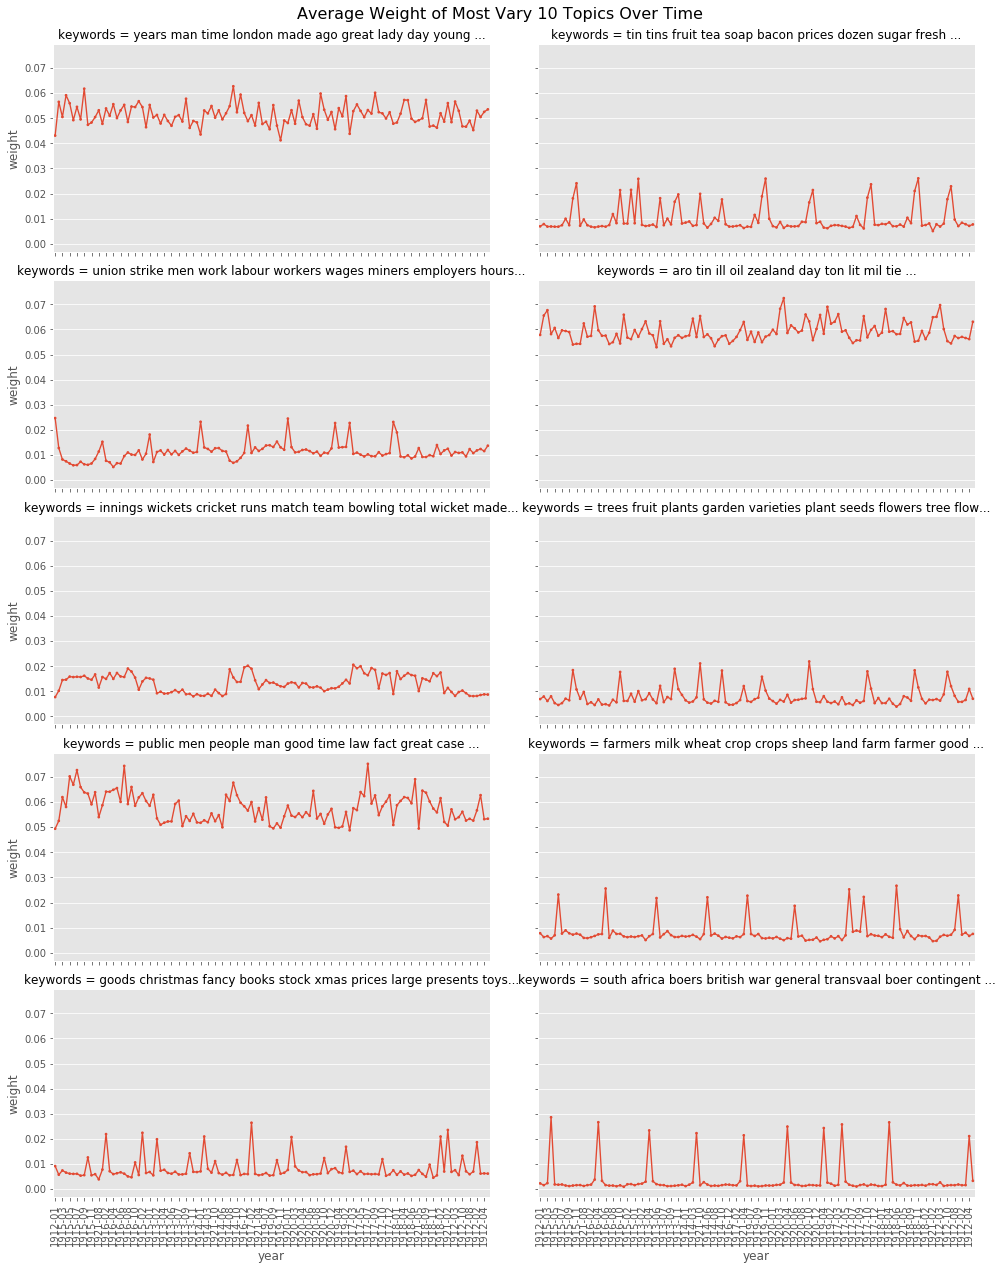

In [45]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

### 2.5 The Most Different Topics

**We calculate the difference of the count of each dominant topic between which from WWI and from other time range (complementary set of WWI), then we get the most different topics of WWI.**

In [81]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of dataframe:', df_plt_dom.shape)
print('Shape of dataframe:', df_plt_avg.shape)

df_join.head()

List of topics to plot: [60, 15, 152, 45, 72, 71, 20, 166, 53, 192]
Shape of dataframe: (448, 6)
Shape of dataframe: (1200, 4)


topic_  weight_  \
60       60  0.03965   
15       15  0.00691   
152     152  0.00852   
45       45  0.00373   
72       72  0.00748   
71       71  0.00977   
20       20  0.00359   
166     166  0.00559   
53       53  0.00370   
192     192  0.00652   

                                                                                    keywords_  \
60          association press received telegraph copyright london united electric july cable    
15   wellington auckland canterbury private christchurch dunedin otago wanganui north napier    
152                  monday saturday tuesday wednesday friday thursday daily moon sunday day    
45                                ewes fat sale cows tooth heifers lambs steers year wethers    
72                          mrs miss misses ladies mesdames lady afternoon smith women's tea    
71                    wanganui avenue victoria marton taupo ridgway quay hill street jackson    
20           auckland wellington left due london lyttelton october august september november    
166                                 car motor cars street model good ford motors sedan order    
53                                 fat sheep good cattle ewes sold prices wethers cows lambs    
192              wellington nelson tons arrived westport morning picton to-morrow port coast    

     topic_wwi  weight_wwi  \
60          60    0.002606   
15          15    0.000601   
152        152    0.000834   
45          45    0.000490   
72          72    0.001148   
71          71    0.001502   
20          20    0.000609   
166        166    0.000948   
53          53    0.000666   
192        192    0.001277   

                                                                                 keywords_wwi  \
60          association press received telegraph copyright london united electric july cable    
15   wellington auckland canterbury private christchurch dunedin otago wanganui north napier    
152                  monday saturday tuesday wednesday friday thursday daily moon sunday day    
45                                ewes fat sale cows tooth heifers lambs steers year wethers    
72                          mrs miss misses ladies mesdames lady afternoon smith women's tea    
71                    wanganui avenue victoria marton taupo ridgway quay hill street jackson    
20           auckland wellington left due london lyttelton october august september november    
166                                 car motor cars street model good ford motors sedan order    
53                                 fat sheep good cattle ewes sold prices wethers cows lambs    
192              wellington nelson tons arrived westport morning picton to-morrow port coast    

          diff  
60   14.215111  
15   10.496554  
152   9.211169  
45    6.618969  
72    5.513720  
71    5.502981  
20    4.898822  
166   4.896475  
53    4.558919  
192   4.105485

**Dominant topics distribution over month:**

In [71]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Dominant topics count over month:**

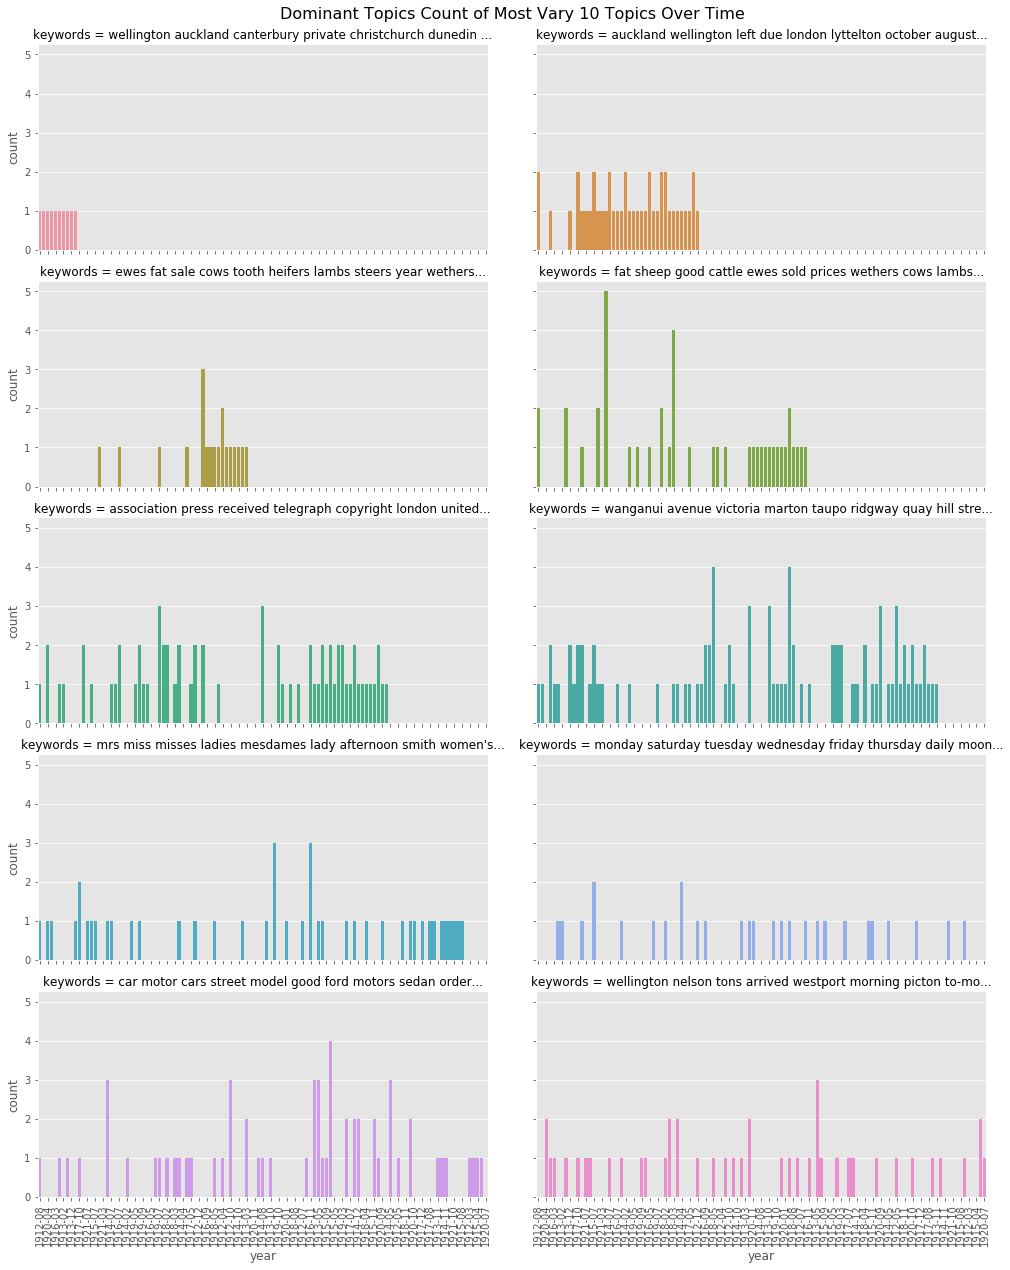

In [72]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)

**Average topic weight over month:**

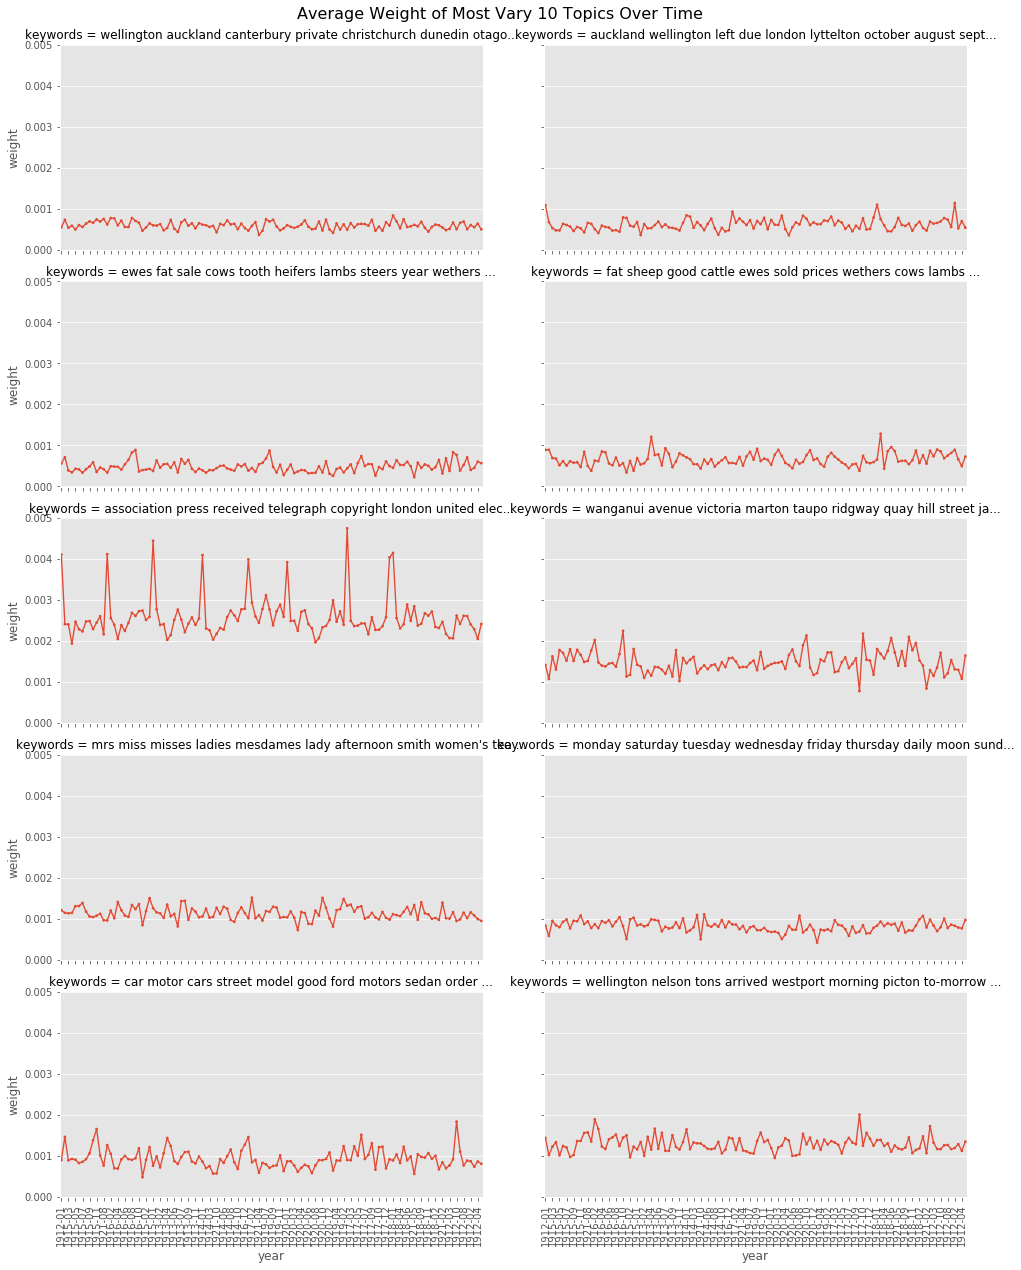

In [73]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='Most Vary 10 Topics',
            height=3.5,
            col_wrap=2)